In [ ]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
import re
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from nltk.translate.bleu_score import corpus_bleu

In [ ]:
Base_dir=r"D:\storygen\flickr8k"
working_dir='models/best_model3.keras'

In [ ]:
model = VGG16()

#restructure the model
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# extract feature from images
features = {}
directory = os.path.join(Base_dir, 'Images')

for img_name in tqdm(os.listdir(directory)): # loop over the directory and returns the list of all files and folder in the directory
    #load image from file
    img_path = os.path.join(directory, img_name)
    image = load_img(img_path, target_size = (224,224), color_mode = 'rgb')
    #convert img pixels to numpy array i.e PIL to nparray
    image = img_to_array(image)
    #reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    #preprocessing image for vgg
    image = preprocess_input(image)
    #extract features
    feature = model.predict(image, verbose = 0)
    #get image id
    image_id = img_name.split('.')[0]
    #store features
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [ ]:
print(f"Total features extracted: {len(features)}")
first_feature = list(features.values())[0]
print("Sample image feature vector:", first_feature)
print("Shape of feature vector:", first_feature.shape)

Total features extracted: 8091
Sample image feature vector: [[2.5076473 0.        0.        ... 0.        0.        0.       ]]
Shape of feature vector: (1, 4096)


In [ ]:
# store features in pickle
pickle.dump(features, open(os.path.join('features.pkl'), 'wb'))

In [ ]:
#load features from pickle
with open(os.path.join('features.pkl'),'rb') as f:
    features = pickle.load(f)

In [ ]:
with open(os.path.join(Base_dir, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [ ]:
mapping = {}

# Process each line in the caption document
for line in tqdm(captions_doc.split('\n')):

    # Split the line by comma(,)
    tokens = line.split(',')

    # Skip any bad lines that don't contain both image ID and caption
    if len(tokens) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]

    # Remove file extension from image ID
    image_id = image_id.split('.')[0]

    # Join the caption list into a single string (in case caption had commas)
    caption = ' '.join(caption)

    # If this image ID is not already in the mapping dictionary, create an empty list
    if image_id not in mapping:
        mapping[image_id] = []

    # Append the current caption to the list of captions for this image ID
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [ ]:
a = list(mapping.keys())[0]
b= list(mapping.values())[0]
print(a)
print(b)

1000268201_693b08cb0e
['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']


In [ ]:
len(mapping)

8091

In [ ]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            # Convert to lowercase
            caption = caption.lower()
            # Remove special characters using regex
            caption = re.sub(r'[^a-z\s]', '', caption)
            # Remove extra whitespace
            caption = re.sub(r'\s+', ' ', caption).strip()
            # Add <start> and <end> tokens
            caption = 'start ' + ' '.join([word for word in caption.split() if len(word) > 1]) + ' end'
            captions[i] = caption

In [ ]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
# preprocess the text
clean(mapping)

In [ ]:
mapping['1000268201_693b08cb0e']

['start child in pink dress is climbing up set of stairs in an entry way end',
 'start girl going into wooden building end',
 'start little girl climbing into wooden playhouse end',
 'start little girl climbing the stairs to her playhouse end',
 'start little girl in pink dress going into wooden cabin end']

In [ ]:
# creates a list of all the captions
all_captions = [caption for captions in mapping.values() for caption in captions]

In [ ]:
# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size =len(tokenizer.word_index) + 1
vocab_size

8766

In [ ]:
# getting max length for padding
max_len = max(len(caption.split()) for caption in all_captions)
max_len

34

In [ ]:
img_ids = list(mapping.keys())
split = int(len(img_ids) * 0.90)
train = img_ids[:split]
test = img_ids[split:]

In [ ]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    x1, x2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into x, y pairs
                for i in range(1, len(seq)):
                    # split into inout and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen = max_len, padding = 'post' )[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes = vocab_size)[0]
                    # store the sequence
                    x1.append(features[key][0])
                    x2.append(in_seq)
                    y.append(out_seq)

            if n == batch_size:
                x1, x2, y = np.array(x1), np.array(x2), np.array(y)
                yield (x1, x2), y

                x1, x2, y = list(), list(), list()
                n = 0

In [ ]:
# ENCODER MODEL

# image feature layers
inputs1 = Input(shape = (4096,))
fe1 = Dropout(0.3)(inputs1)
fe2 = Dense(256, activation = 'relu')(fe1)

# sequence feature layers
inputs2 = Input(shape = (max_len,))
se1 = Embedding(vocab_size, 256, mask_zero = True)(inputs2)
se2 = Dropout(0.3)(se1)
se3 = LSTM(256)(se2)

# DECODER MODEL
decoder1 = add([fe2,se3])
decoder2 = Dense(256, activation = 'relu')(decoder1)
outputs = Dense(vocab_size, activation = 'softmax')(decoder2)

model = Model(inputs= [inputs1, inputs2], outputs = outputs)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 34)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 4096)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 34, 256)              2244096   ['input_3[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 4096)                 0         ['input_2[0][0]']             
                                                                                            

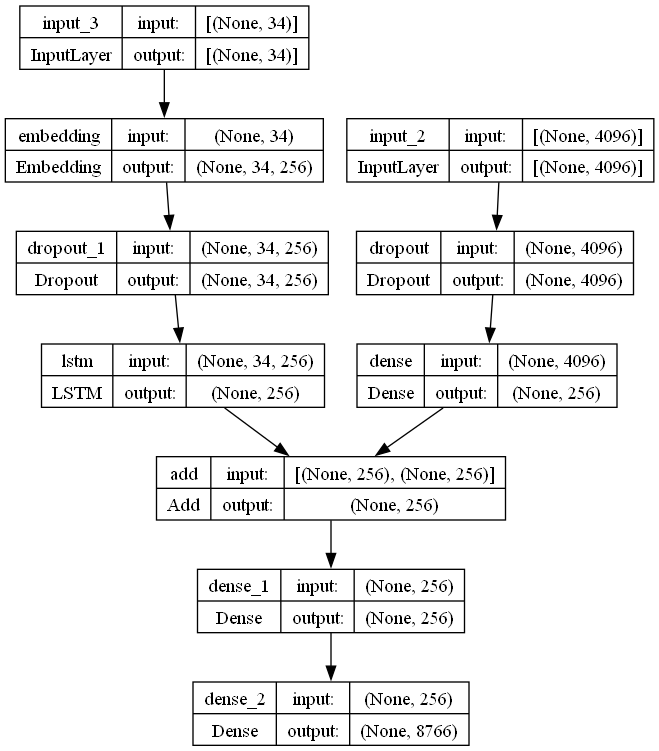

In [ ]:
plot_model(model, show_shapes = True)

In [ ]:
# Create the dataset once
batch_size = 32
steps = len(train) // batch_size*2
epochs = 10
train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(train, mapping, features, tokenizer, max_len, vocab_size, batch_size),
    output_signature=(
        (
            tf.TensorSpec(shape=(None, 4096), dtype=tf.float32),
            tf.TensorSpec(shape=(None, max_len), dtype=tf.int32)
        ),
        tf.TensorSpec(shape=(None, vocab_size), dtype=tf.float32)
    )
)

model.fit(train_dataset, epochs=epochs, steps_per_epoch=steps, verbose=1)

Epoch 1/10
454/454 [==============================] - 387s 846ms/step - loss: 4.5782
Epoch 2/10
454/454 [==============================] - 375s 827ms/step - loss: 3.3975
Epoch 3/10
454/454 [==============================] - 379s 836ms/step - loss: 2.9946
Epoch 4/10
454/454 [==============================] - 380s 838ms/step - loss: 2.7651
Epoch 5/10
454/454 [==============================] - 381s 839ms/step - loss: 2.5989
Epoch 6/10
454/454 [==============================] - 385s 847ms/step - loss: 2.4731
Epoch 7/10
454/454 [==============================] - 420s 925ms/step - loss: 2.3749
Epoch 8/10
454/454 [==============================] - 435s 958ms/step - loss: 2.2859
Epoch 9/10
454/454 [==============================] - 445s 979ms/step - loss: 2.2067
Epoch 10/10
454/454 [==============================] - 447s 985ms/step - loss: 2.1408


In [ ]:
model.save('/best_model.h5')

c:\Users\admin\anaconda3\envs\myenv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
# Generate caption for the image

def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'start'
    #iterate over the max length of the sequence
    for i in range(max_len):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad sequences
        sequence = pad_sequences([sequence], max_len, padding = 'post')
        # predict next word
        y_hat = model.predict([image, sequence], verbose = 0)
        # get index with high probability
        y_hat = np.argmax(y_hat)
        # convert index to word
        word = idx_to_word(y_hat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # break word as inputp for generating next word
        in_text += " " + word
        #stop if we reach end tag
        if word == 'end':
            break
    return in_text

In [ ]:
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    #get acutal caption
    captions = mapping[key]
    #predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_len)
    actual_captions = [caption.split() for caption in captions]

    # split into words
    y_pred = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)


# calculate BLEU score

print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights = (1.0, 0, 0 ,0)))
print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights = (0.5, 0.5, 0 ,0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.563840
BLEU-2: 0.343448


In [ ]:
def generate_captions(*image_names):
    plt.figure(figsize=(9, 9))

    for idx, image_name in enumerate(image_names):
        image_id = image_name.split('.')[0]
        img_path = os.path.join(Base_dir, 'Images', image_name)
        image = Image.open(img_path)

        # Get actual captions
        actual_captions = mapping[image_id]
        actual_text = "\n".join([cap.replace("start", "").replace("end", "").strip() for cap in actual_captions])

        # Predict caption
        predicted_caption = predict_caption(model, features[image_id], tokenizer, max_len)
        predicted_text = predicted_caption.replace("start", "").replace("end", "").strip()

        # Display image
        plt.subplot(2, 2, idx + 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"Actual:\n{actual_text}\n\nPredicted:\n{predicted_text}", fontsize=8)

    plt.tight_layout()
    plt.show()

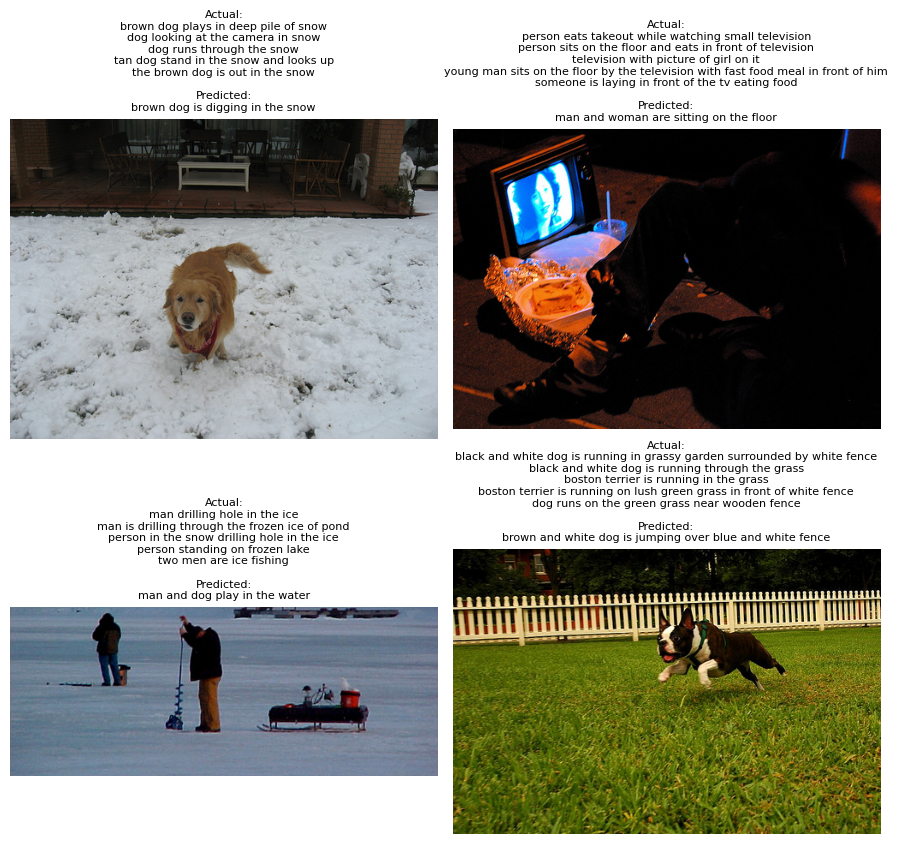

In [ ]:
generate_captions('1094462889_f9966dafa6.jpg','1045521051_108ebc19be.jpg','102351840_323e3de834.jpg','1009434119_febe49276a.jpg')

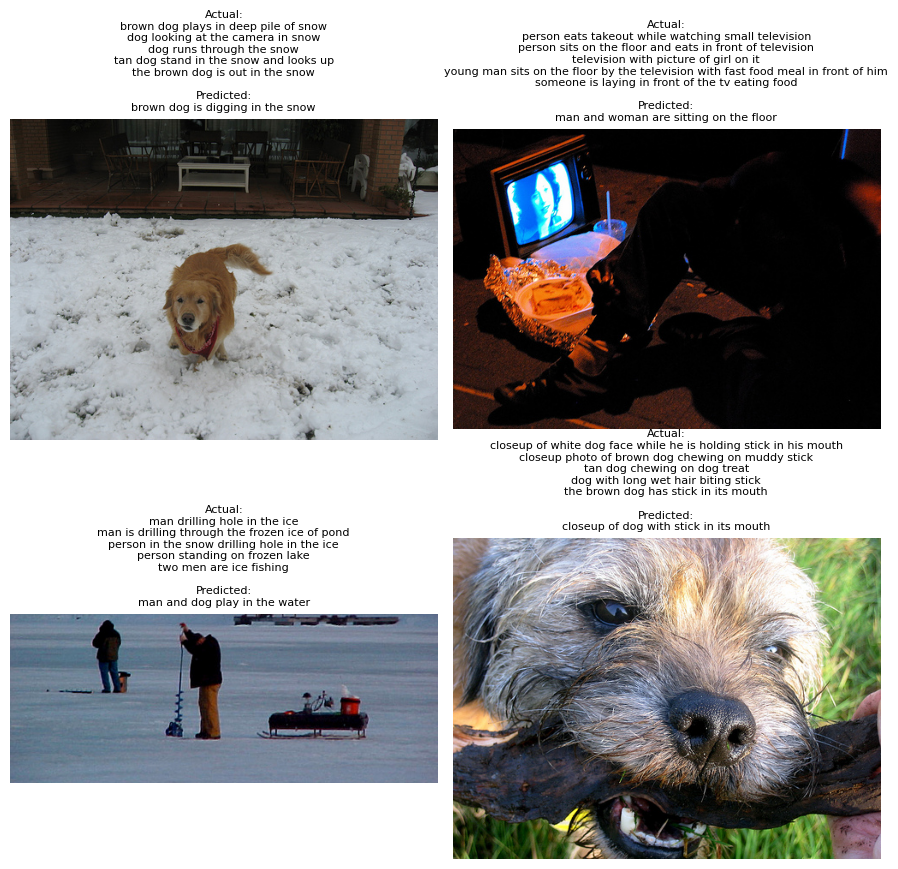

In [ ]:
generate_captions('1094462889_f9966dafa6.jpg','1045521051_108ebc19be.jpg','102351840_323e3de834.jpg','313051099_1bb87d6c56.jpg')